In [1]:
import numpy as np
import matplotlib.pyplot as plt

import itertools
from scipy import integrate
from scipy.stats import multivariate_normal,norm

from tqdm import tqdm


## Branin function 2D
Has minimum in [-np.pi, 12.275]

Text(0.5, 0, 'z')

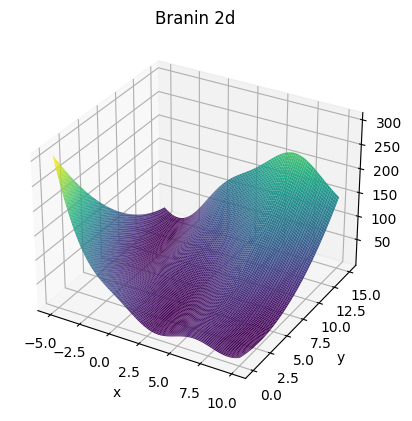

In [2]:


def branin(x): 
    # x is a 2D array x[0] and x[1] respectively x and y
    a = 1
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    return a * (x[1] - b * x[0]**2 + c * x[0] - r)**2 + s * (1 - t) * np.cos(x[0]) + s

# Define the range of x and y values
x = np.linspace(-5, 10, 100)
y = np.linspace(0, 15, 100)

# Create a grid of x and y values
X = np.meshgrid(x, y)
# Evaluate the Branin function for each combination of x and y
Z = branin(X)



fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X[0], X[1], Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Branin 2d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')



## Rosen function 
- $x_i$ in $R^{dim}$
- has minimum in $x_i$ = 1
- f($x_i$) = 0

Text(0.5, 0, 'z')

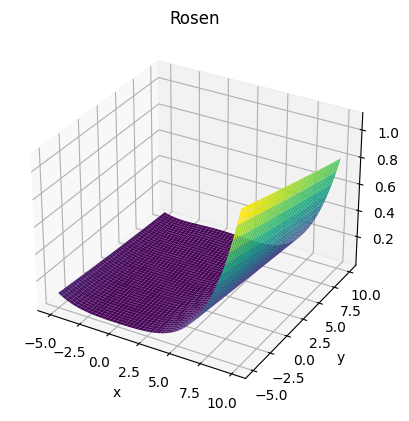

In [3]:


x1 = np.linspace(-5, 10)
x2 = np.linspace(-5, 10)
X1, X2 = np.meshgrid(x1, x2)

def rosen(x):
    #https://www.indusmic.com/post/rosenbrock-function
    #x is a list
    #check dimensions of x
    dims = len(x)
    z=0
    for i in range(dims-1):

        z += 100*(x[i+1]-x[i]**2)**2+(x[i]-1)**2

    return z

Z = rosen([X1, X2])


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Rosen')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [4]:
# Utilities
def mu(k, Sigma_inv, y):
    """
    Mean of the marginal distribution of f(x)

    Parameters
    ----------
    k : array_like
        kernel vector w.r.t. the previous observations
    Sigma_inv : array_like
        inverse covariance matrix of the previous observations
    y : array_like 
        previous observations

    Returns
    -------
    float
        mean of the marginal distribution of f(x)
    """
    return k.T @ Sigma_inv @ y

def sigma(Kx, k, Sigma_inv):
    """
    Variance of the marginal distribution of f(x)

    Parameters
    ----------
    Kx : array_like
        kernel vector w.r.t. the new observation K(x, x)
    k : array_like
        kernel vector w.r.t. the previous observations
    Sigma_inv : array_like
        inverse covariance matrix of the previous observations

    Returns
    -------
    float
        variance of the marginal distribution of f(x)
    """
    
    return Kx - k.T @ Sigma_inv @ k

def kernel_se(x1, x2, l=1, s=1):
    """
    Squared exponential kernel

    Parameters
    ----------
    x1 : float
        First input
    x2 : float
        Second input
    l : array_like
        Length scale
    s : float
        Signal variance
    
    Returns
    -------
    float
        Squared exponential kernel
    """
    # check if l is scalar or vector
    if np.isscalar(l):
        return s*np.exp(-1/(2*l**2)*np.sum((x1-x2)**2))
    else:
        s*np.exp(-1/2*np.sum((x1-x2)**2/l**2))

def kernel_M52(x1, x2, l=None, s=1):
    """
    Matern 5/2 kernel

    Parameters
    ----------
    x1 : array_like
        First input
    x2 : array_like
        Second input
    l : array_like 
        Length scales
    s : float
        Signal variance
    """

    # initialize length scale if not provided
    if l is None:
        l = np.ones(len(x1))

    # # check if l and x have the same dimension
    if np.isscalar(l):
        if len(x1) != 1:
            raise ValueError('Dimension of x and l must be the same')
    elif len(x1) != len(l):
        raise ValueError('Dimension of x and l must be the same')
    r2 = np.sum(((x1-x2)/l)**2)
    return s*(1 + np.sqrt(5*r2) + 5/3*r2)*np.exp(-np.sqrt(5*r2))
        

def generate_combinations(dictionary):
    """
    Generate all combinations of values in a dictionary
    """
    keys = list(dictionary.keys())
    value_lists = [dictionary[key] for key in keys]
    combinations = list(itertools.product(*value_lists))
    return combinations


def likelihood(theta, x, y, kernel, loop_number):
    """ 
    Likelihood function for the GP hyperparameters (function of theta, given data (x, y))

    Parameters
    ----------
    theta : array_like
        Hyperparameters
    y : array_like
        Observations
    x : array_like
        Sample points (raws hyperparameters, columns observations)
    kernel : function
        Kernel function
    loop_number : int
        Number of the loop for which the likelihood is computed

    Returns
    -------
    float
        Likelihood
    """
    # compute covariance matrix
    l = loop_number
    K = np.zeros((l, l))
    for i in range(l):
        for j in range(l):
            # no negative s
            K[i, j] = kernel(x[:, i], x[:, j], l=theta[1:], s=np.abs(theta[0])+1e-6)
    like = multivariate_normal(mean=np.zeros(len(y)), cov=K)
    return like.pdf(y)



In [5]:
# Expected improvement 

def acq_func_EI(y_best, mu, sigma):
    """
    Expected improvement acquisition function

    Parameters
    ----------
    y_best : float
        Best observed function value
    mu : float
        Mean of the predictive distribution
    sigma : float
        Standard deviation of the predictive distribution
    
    Returns
    -------
    float
        Expected improvement acquisition function value
    """ 
    # initialize standard normal distribution
    stand_norm = multivariate_normal(mean=[0], cov=[[1]])
    epsilon = 1e-6  # Small epsilon value to prevent division by zero
    z = (y_best - mu) / (sigma + epsilon)
    return (z*stand_norm.cdf(z) + stand_norm.pdf(z)) * sigma

def acq_func_PI(y_best, mu, sigma):
    """
    Probability of Improvement acquisition function

    Parameters
    ----------
    y_best : float
        Best observed function value
    mu : float
        Mean of the predictive distribution
    sigma : float
        Standard deviation of the predictive distribution
    
    Returns
    -------
    float
        Probability of Improvement acquisition function value
    """ 
    gamma = y_best - mu
    z = gamma / sigma
    return norm.cdf(z)

def acq_func_UCB(mu, sigma, kappa):
    """
    Upper Confidence Bound (UCB) acquisition function

    Parameters
    ----------
    mu : float
        Mean of the predictive distribution
    sigma : float
        Standard deviation of the predictive distribution
    kappa : float
        Tunable parameter to balance exploitation against exploration
    
    Returns
    -------
    float
        Upper Confidence Bound (UCB) acquisition function value
    """ 
    return mu - kappa * sigma



In [6]:
def bayes_optimization(hyp_space, n_sample, n_wu, acq_function, kernel, s, l, f, **kwargs):
    """
    Bayesian optimization for hyperparameter tuning

    Parameters
    ----------
    hyp_space : dict
        hyperparameter dictionary 
    n_sample : int
        number of samples to draw
    n_wu : int
        number of warmup samples
    acq_function : function
        acquisition function
    kernel : function
        kernel function
    s : float
        signal variance
    l : array_like
        length scales
    f : function
        function to optimize
    **kwargs : dict
        additional arguments for the acquisition function (such as loss, x_train, y_train, etc.)
        
    Returns
    -------
    hyp : array_like
        hyperparameter values
    """
    y_best_vec = np.array([])
    best_hyp = np.array([])
    y_sampled = np.array([])
    hyp_name = list(hyp_space.keys())
    y_best = np.inf

    # all possible combinations of hyperparameters (each row is a combination)
    hyp_space_combinations = np.array(generate_combinations(hyp_space))

    # check if the number of samples is greater than the number of possible combinations
    if n_sample > len(hyp_space_combinations):
        raise ValueError('The number of samples is greater than the number of possible combinations')

    # Warm up phase

    # random sampling from hyperparameter space
    # matrix of sampled values (rows: hyperparameters, columns: samples)
    x_sampled = np.zeros((len(hyp_name), n_sample+n_wu))
    for j in range(n_wu):
        #print(f"Warm-up sample {j+1}/{n_wu}...")
        # sample hyperparameters from the hyperparameter space
        np.random.shuffle(hyp_space_combinations)
        x_sampled[:, j] = hyp_space_combinations[0]
        # delete the sampled value from the hyperparameter combinations 
        hyp_space_combinations = np.delete(hyp_space_combinations, 0, axis=0)
        # evaluate function
        y = f(x_sampled[:, j], **kwargs)
        y_sampled = np.append(y_sampled, y)
        # update y_best
        if y < y_best:
            y_best = y
            best_hyp = x_sampled[:, j]
        # append y_best to y_best_vec
        y_best_vec = np.append(y_best_vec, y_best)
    #print("Warm-up phase completed.")
    # sampling
        
    for j in tqdm(range(n_wu, n_sample+n_wu)):
        #print(f"Sample {j+1}/{n_sample+n_wu}...")
        acq_max = -np.inf

        # update kernel matrix
        if j == n_wu:
            K = np.zeros((n_wu, n_wu))
            for i in range(n_wu):
                for k in range(n_wu):
                    K[i, k] = kernel(x_sampled[:, i], x_sampled[:, k], l, s) 
        else:
            # add new row and column to kernel matrix
            K = np.pad(K, pad_width=(0,1), mode='constant', constant_values=0)
            # update new row and column
            for i in range(j):
                K[i, j-1] = kernel(x_sampled[:, i], x_sampled[:, j-1], l, s)
                K[j-1, i] = K[i, j-1]

        # compute the acquisition function for each possible value of the hyperparameters vector, keeping only the maximum while updating the hyperparameters
        # and sampling the new hyperparameters vector
        K_inv = np.linalg.inv(K)
        for xs in hyp_space_combinations:
            # compute the kernel vector
            k = np.array([kernel(x_sampled[:, v], xs, l, s) for v in range(j)])
            acq = acq_function(y_best, mu(k, K_inv, y_sampled), sigma(kernel(xs, xs, l, s), k, K_inv))
            # check if the new value is the maximum
            if acq > acq_max:
                acq_max = acq
                tmp_x_sampled = xs
        
        # update x_sampled
        x_sampled[:, j] = tmp_x_sampled
        # delete the sampled value from the hyperparameter combinations  
        hyp_space_combinations = np.delete(hyp_space_combinations, np.where((hyp_space_combinations == tmp_x_sampled).all(axis=1))[0][0], axis=0)   
        # evaluate function
        y = f(x_sampled[:, j], **kwargs)
        y_sampled = np.append(y_sampled, y)
        # update y_best
        if y < y_best:
            y_best = y
            best_hyp = x_sampled[:, j]
        # append y_best to y_best_vec
        y_best_vec = np.append(y_best_vec, y_best)
    #print("Sampling phase completed.")

    return best_hyp, y_best_vec, x_sampled, y_sampled

## GP on branin 2d

### Random search function


In [8]:

def random_search(hyp_space, n_sample, f):
    #implement a random search for comparison
    losses_random = np.array([])
    best_hyp_random = np.array([])
    x_sampled_random = np.array([])
    loss_sampled_random = np.array([])
    loss_best_random = np.inf


    hyp_space_combinations = np.array(generate_combinations(hyp_space))
    x_sampled_random = np.zeros((len(hyp_space), n_sample))

    for j in range(n_sample):
        # sample hyperparameters from the hyperparameter space
        np.random.shuffle(hyp_space_combinations)
        #sample a hyperparameter combination
        x_sampled_random[:,j] = hyp_space_combinations[0]
        # delete the sampled value from the hyperparameter combinations 
        hyp_space_combinations = np.delete(hyp_space_combinations, np.where((hyp_space_combinations == x_sampled_random[:, j]).all(axis=1))[0][0], axis=0)

        # evaluate loss for training with those hyperparameters
        loss = f(x_sampled_random[:, j])
        loss_sampled_random = np.append(loss_sampled_random, loss)
        # update loss_best
        if loss < loss_best_random:
            loss_best_random = loss
            best_hyp_random = x_sampled_random[:, j]
        # append loss_best to loss_best_vec
        losses_random = np.append(losses_random, loss_best_random)

    return best_hyp_random, loss_best_random, x_sampled_random, losses_random




## Comparison between GP and Random search

In [42]:

# Create a dictionary for the hyperparameter space
hyperparameters = {"x1": np.linspace(-5, 10, 30), 
                   "x2": np.linspace(0, 15, 30)}

len(generate_combinations(hyperparameters))


900

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x16bcd56a0>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x16bce6940>)

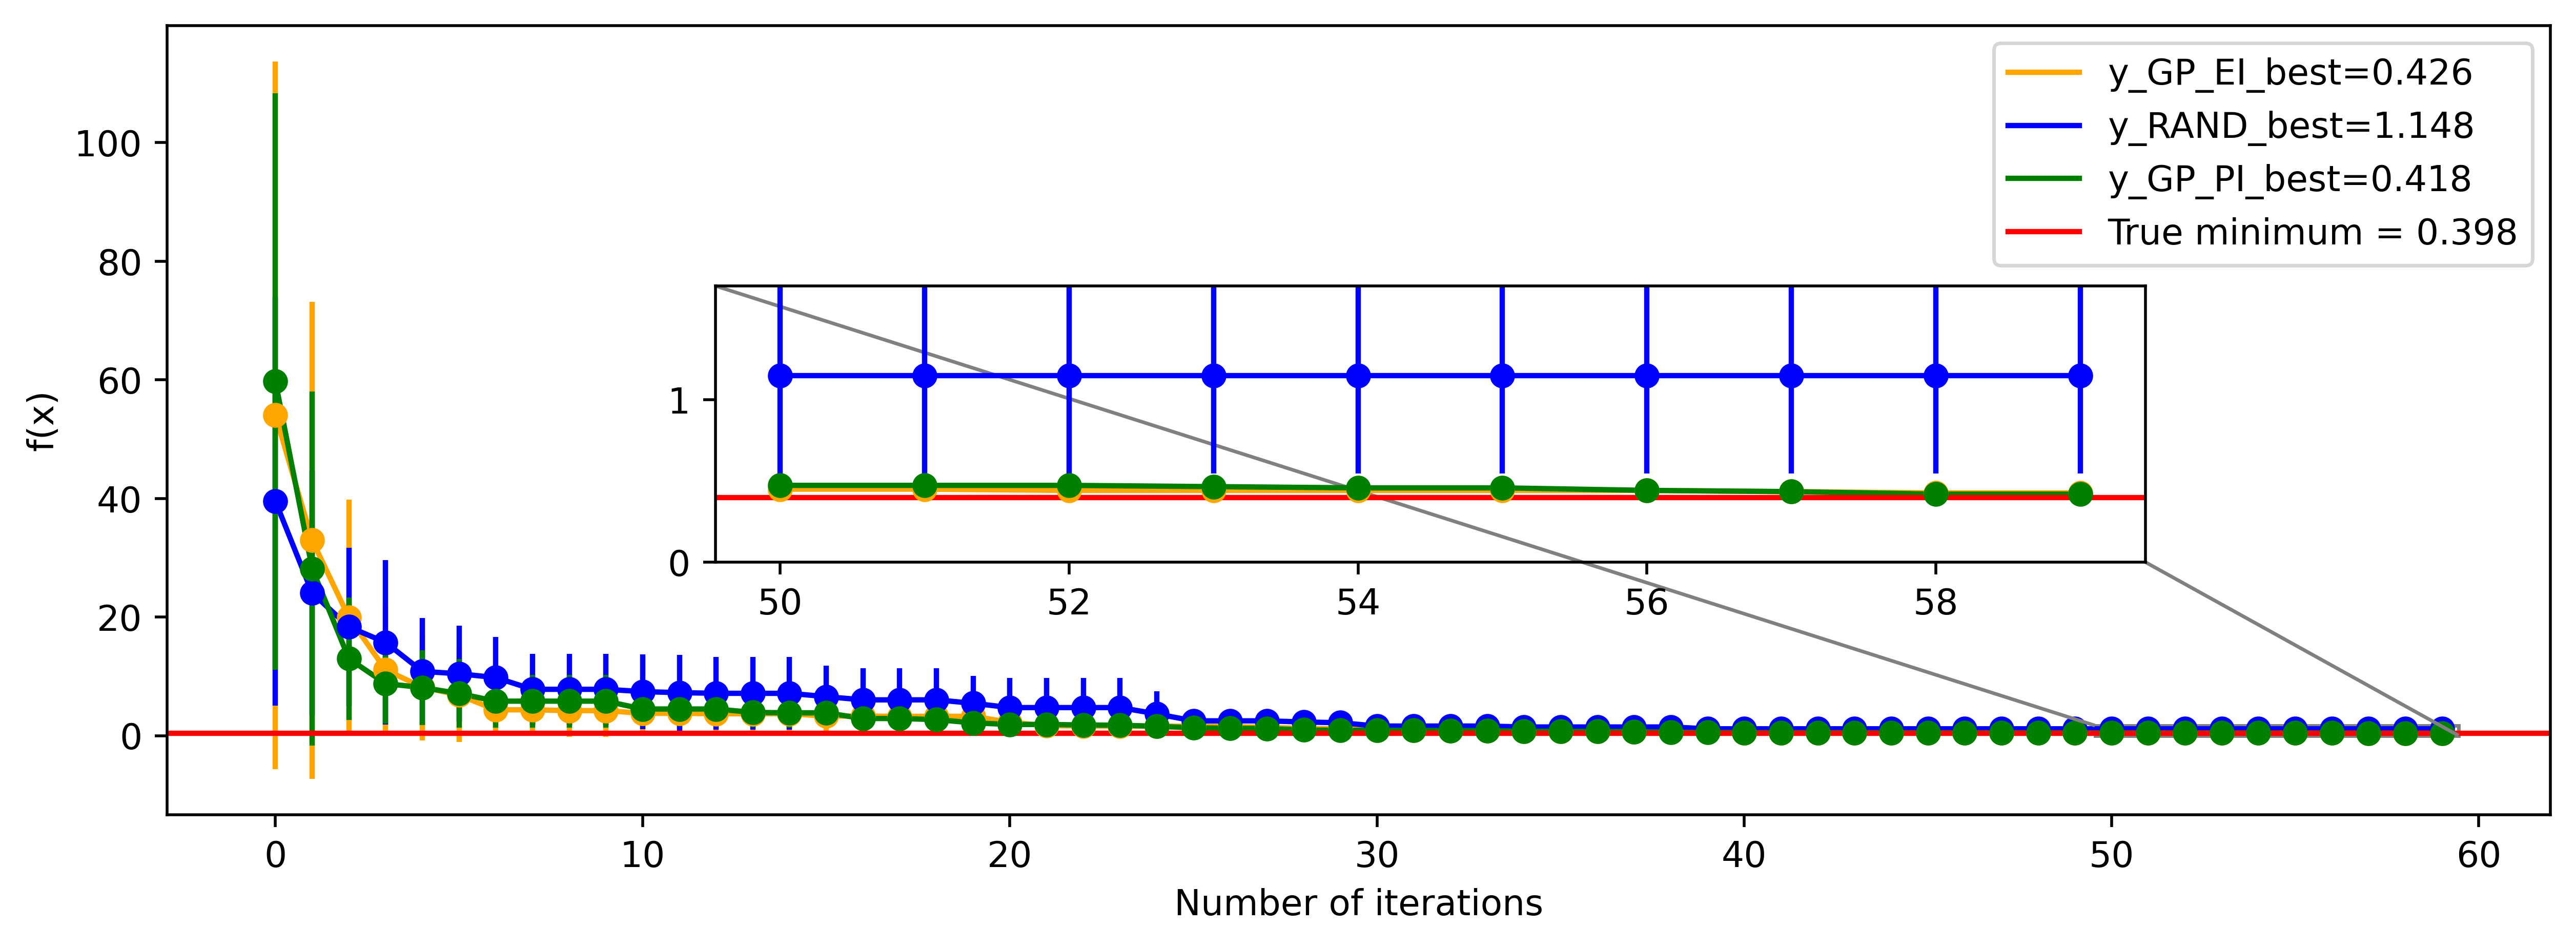

In [43]:

# Create a dictionary for the hyperparameter space
hyperparameters = {"x1": np.linspace(-5, 10, 30), 
                   "x2": np.linspace(0, 15, 30)}


n_sample = 50
n_wu = 10
n_test = 10
n_total = n_sample + n_wu

losses_bv = np.zeros((n_test, n_total))
losses_random = np.zeros((n_test, n_total))
losses_bv_PI = np.zeros((n_test, n_total))

for i in range(n_test):
    best_hyperparams_bv, losses_bv[i], x_sampled_bv, losses = bayes_optimization(hyperparameters, n_sample, n_wu, acq_func_EI, kernel_M52,s=1,l=[1,1], f=branin)
    best_hyperparams_bv_PI, losses_bv_PI[i], x_sampled_bv_PI, losses_PI = bayes_optimization(hyperparameters, n_sample, n_wu, acq_func_PI, kernel_M52,s=1,l=[1,1], f=branin)
    best_hyperparams_random, loss_best_random, x_sampled_random, losses_random[i] = random_search(hyperparameters, n_total, branin)


fig, ax = plt.subplots(figsize=(12, 4), dpi=500)


ax.plot(np.mean(losses_bv, axis=0), label=f'y_GP_EI_best={np.round(np.mean(losses_bv[:,-1]),3)}', color='orange')
ax.plot(np.mean(losses_random, axis=0), label=f'y_RAND_best={np.round(np.mean(losses_random[:,-1]),3)}', color='b')
ax.plot(np.mean(losses_bv_PI, axis=0), label=f'y_GP_PI_best={np.round(np.mean(losses_bv_PI[:,-1]),3)}', color='g')

plt.errorbar(np.arange(n_total), np.mean(losses_bv, axis=0), yerr=np.std(losses_bv, axis=0), fmt='o', color='orange')
plt.errorbar(np.arange(n_total), np.mean(losses_random, axis=0), yerr=np.std(losses_random, axis=0), fmt='o', color='b')
plt.errorbar(np.arange(n_total), np.mean(losses_bv_PI, axis=0), yerr=np.std(losses_bv_PI, axis=0), fmt='o', color='g')

#plot horintal line at true minimum
ax.axhline(y=branin([-np.pi, 12.275]), color='r', linestyle='-', label='True minimum = {}'.format(np.round(branin([-np.pi, 12.275]),3)))
ax.set_xlabel('Number of iterations')
ax.set_ylabel('f(x)')
ax.legend(loc="best")

idx=50
# Create zoom inset
axins = ax.inset_axes([0.23, 0.32, 0.6, 0.35])
axins.plot(np.arange(n_total)[idx:],np.mean(losses_bv, axis=0)[idx:],color='orange' )
axins.plot(np.arange(n_total)[idx:],np.mean(losses_random, axis=0)[idx:],color='b' )
axins.plot(np.arange(n_total)[idx:],np.mean(losses_bv_PI, axis=0)[idx:],color='g' )
axins.axhline(y=branin([-np.pi, 12.275]), color='r', linestyle='-', label='True minimum = {}'.format(np.round(branin([-np.pi, 12.275]),3)))

axins.errorbar(np.arange(n_total)[idx:], np.mean(losses_bv, axis=0)[idx:], yerr=np.std(losses_bv, axis=0)[idx:], fmt='o', color='orange')
axins.errorbar(np.arange(n_total)[idx:], np.mean(losses_random, axis=0)[idx:], yerr=np.std(losses_random, axis=0)[idx:], fmt='o', color='b')
axins.errorbar(np.arange(n_total)[idx:], np.mean(losses_bv_PI, axis=0)[idx:], yerr=np.std(losses_bv_PI, axis=0)[idx:], fmt='o', color='g')
axins.set_ylim(0,1.7)
# Add border around the zoom inset
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")





For dim=2 Random search and GP are similar in founding the minimum

## 3D Rosen Comparision

In [50]:
hyperparameters = {"x1": np.linspace(-5, 10, 15), "x2": np.linspace(-5, 10, 15),
             "x3": np.linspace(-5, 10, 15)} 

print("total combinations", len(generate_combinations(hyperparameters)))

total combinations 3375


In [51]:
# 5 min



n_sample = 50
n_wu = 5
n_total = n_sample+n_wu
n_test = 10
losses_bv = np.zeros((n_test, n_sample+n_wu))
losses_random = np.zeros((n_test, n_sample+n_wu))
for i in range(n_test):
    best_hyperparams_bv, losses_bv[i], x_sampled_bv, losses= bayes_optimization(hyperparameters, n_sample, n_wu, acq_func_EI, kernel_M52, s=1, l=[1,1,1],f=rosen)
    best_hyperparams_random, loss_best_random, x_sampled_random, losses_random[i] = random_search(hyperparameters, n_total, rosen)




100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


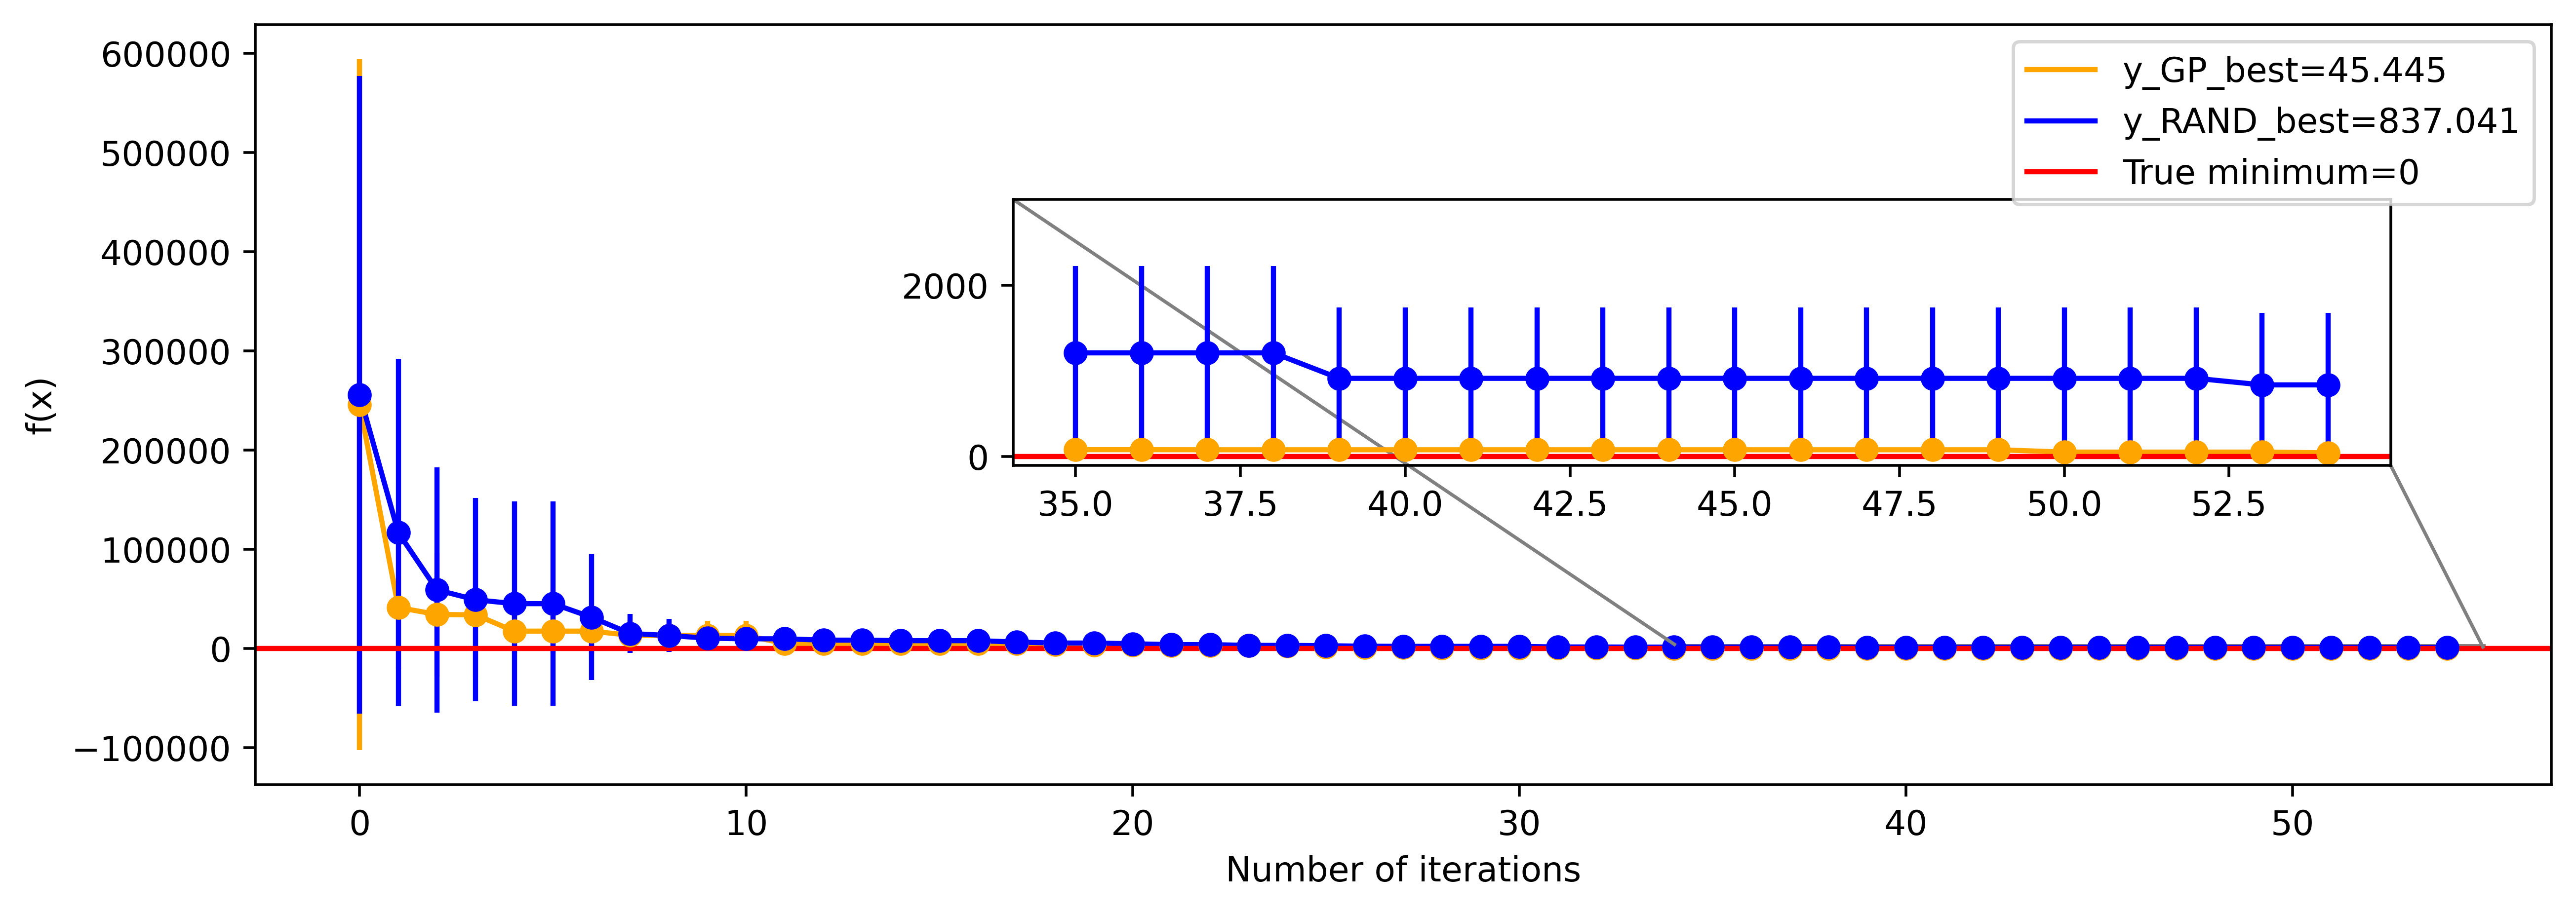

In [58]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=500)


ax.plot(np.mean(losses_bv, axis=0), label=f'y_GP_best={np.round(np.mean(losses_bv[:,-1]),3)}', color='orange')
ax.plot(np.mean(losses_random, axis=0), label=f'y_RAND_best={np.round(np.mean(losses_random[:,-1]),3)}', color='b')

plt.errorbar(np.arange(n_total), np.mean(losses_bv, axis=0), yerr=np.std(losses_bv, axis=0), fmt='o', color='orange')
plt.errorbar(np.arange(n_total), np.mean(losses_random, axis=0), yerr=np.std(losses_random, axis=0), fmt='o', color='b')

#plot horintal line at true minimum
ax.axhline(y=0, color='r', linestyle='-', label='True minimum=0')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('f(x)')
ax.legend()

idx=35
# Create zoom inset
axins = ax.inset_axes([0.33, 0.42, 0.6, 0.35])
axins.plot(np.arange(n_total)[idx:],np.mean(losses_bv, axis=0)[idx:],color='orange' )
axins.plot(np.arange(n_total)[idx:],np.mean(losses_random, axis=0)[idx:],color='b' )
axins.axhline(y=0, color='r', linestyle='-', label='True minimum=0')
axins.errorbar(np.arange(n_total)[idx:], np.mean(losses_bv, axis=0)[idx:], yerr=np.std(losses_bv, axis=0)[idx:], fmt='o', color='orange')
axins.errorbar(np.arange(n_total)[idx:], np.mean(losses_random, axis=0)[idx:], yerr=np.std(losses_random, axis=0)[idx:], fmt='o', color='b')
axins.set_ylim(-100,3000)
# Add border around the zoom inset
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()